In [ ]:
## Importing the necessary packages


import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D,Reshape
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

In [ ]:
## Loading the dataset

## Loading the numpy arrays

dir = '/content/drive/Shareddrives/EE147/project_data/'
X_test = np.load(dir+"X_test.npy")
y_test = np.load(dir+"y_test.npy")
person_train_valid = np.load(dir+"person_train_valid.npy")
X_train_valid = np.load(dir+"X_train_valid.npy")
y_train_valid = np.load(dir+"y_train_valid.npy")
person_test = np.load(dir+"person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))



Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Preprocessing the dataset and preparing the training, validation, and test datasets

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data
    X = X[:,:,0:750]
    
    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
        
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,3,3,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,3,3,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

    

        


(10575, 22, 250)
(10575,)
(2215, 22, 250)
(2215,)


In [ ]:
# random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
y_test = to_categorical(y_test_prep, 4)

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_valid.shape)
print (y_valid.shape)

(6960, 250, 1, 22)
(6960, 4)
(2215, 250, 1, 22)
(2215, 4)
(1500, 250, 1, 22)
(1500, 4)


## Building a basic CNN model and then training, validating and testing it.

In [ ]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 50

#Building the model

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Third block of conv.
cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Fourth block of conv.
cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)








Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_12 (Dropout)         (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 1, 50)        

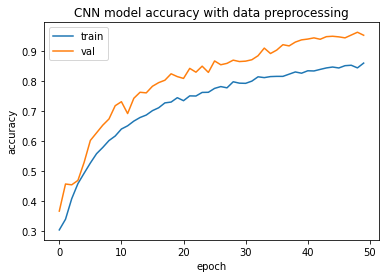

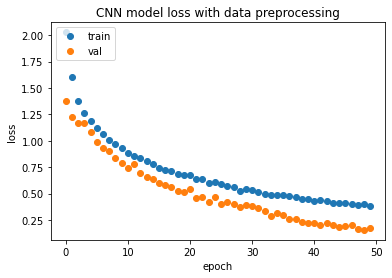

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('CNN model accuracy with data preprocessing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_results.history['loss'],'o')
plt.plot(cnn_results.history['val_loss'],'o')
plt.title('CNN model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the CNN model

score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN model:',score[1])

Test accuracy of the CNN model: 0.7069977521896362


## Building a basic CNN-LSTM model and then training, validating and testing it.

In [ ]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 100

#Building the model

cnn_lstm_model = Sequential()

# First block of conv.
cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# Second block of conv.
cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# Third block of conv.
cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# FC+LSTM layer
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense((50)))
cnn_lstm_model.add(Reshape((50,1)))
cnn_lstm_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=False))

# FC layer
cnn_lstm_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_lstm_model.summary()

# Training and validating the model

cnn_lstm_results = cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)










Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_49 (Dropout)         (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 28, 1, 50)       

109/109 [==============================] - 7s 68ms/step - loss: 0.7017 - accuracy: 0.7230 - val_loss: 0.5165 - val_accuracy: 0.8353
Epoch 40/100
109/109 [==============================] - 7s 68ms/step - loss: 0.6819 - accuracy: 0.7446 - val_loss: 0.5561 - val_accuracy: 0.8100
Epoch 41/100
109/109 [==============================] - 7s 67ms/step - loss: 0.6744 - accuracy: 0.7473 - val_loss: 0.4869 - val_accuracy: 0.8493
Epoch 42/100
109/109 [==============================] - 8s 71ms/step - loss: 0.6573 - accuracy: 0.7528 - val_loss: 0.4470 - val_accuracy: 0.8607
Epoch 43/100
109/109 [==============================] - 8s 71ms/step - loss: 0.6487 - accuracy: 0.7607 - val_loss: 0.4612 - val_accuracy: 0.8567
Epoch 44/100
109/109 [==============================] - 8s 69ms/step - loss: 0.6381 - accuracy: 0.7632 - val_loss: 0.4481 - val_accuracy: 0.8607
Epoch 45/100
109/109 [==============================] - 8s 69ms/step - loss: 0.6146 - accuracy: 0.7784 - val_loss: 0.4183 - val_accuracy: 0.866

109/109 [==============================] - 8s 71ms/step - loss: 0.3983 - accuracy: 0.8541 - val_loss: 0.1693 - val_accuracy: 0.9540
Epoch 96/100
109/109 [==============================] - 8s 72ms/step - loss: 0.4051 - accuracy: 0.8554 - val_loss: 0.1755 - val_accuracy: 0.9547
Epoch 97/100
109/109 [==============================] - 8s 71ms/step - loss: 0.4159 - accuracy: 0.8462 - val_loss: 0.1512 - val_accuracy: 0.9580
Epoch 98/100
109/109 [==============================] - 8s 71ms/step - loss: 0.4020 - accuracy: 0.8560 - val_loss: 0.1379 - val_accuracy: 0.9620
Epoch 99/100
109/109 [==============================] - 8s 71ms/step - loss: 0.4091 - accuracy: 0.8497 - val_loss: 0.1452 - val_accuracy: 0.9587
Epoch 100/100
109/109 [==============================] - 8s 72ms/step - loss: 0.3904 - accuracy: 0.8619 - val_loss: 0.1602 - val_accuracy: 0.9547


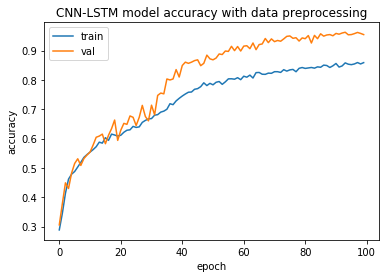

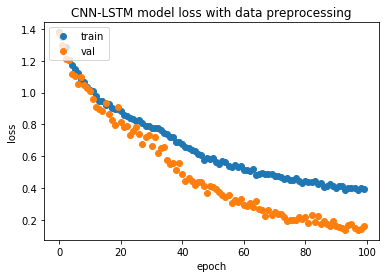

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_lstm_results.history['accuracy'])
plt.plot(cnn_lstm_results.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy with data preprocessing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_lstm_results.history['loss'],'o')
plt.plot(cnn_lstm_results.history['val_loss'],'o')
plt.title('CNN-LSTM model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the CNN-LSTM model

score = cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN-LSTM model:',score[1])

Test accuracy of the CNN-LSTM model: 0.70033860206604
